# 1. Colab 환경 설정

####실행에 필요한 라이브러리와 KoBERT 모델을 불러온다

In [ ]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

#Kobert 파일 로드 from github
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     |████████████████████████████████| 47.3 MB 59.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=02c7a579636628e5e0f54358a9953cd913c20d46cd414bf67797894f9ec1ddf6
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13

####필요한 모듈을 import

In [ ]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm import tqdm, notebook
import random

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

####구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/capstone_design/

Mounted at /content/drive
/content/drive/MyDrive/capstone_design


# 2. 데이터셋 전처리

####구글 드라이브에서 데이터 파일 읽어오기

In [ ]:
test_data = pd.read_excel('웰니스_챗봇_말뭉치_데이터셋.xlsx')

####사용자 말 데이터만 뽑기

In [ ]:
wellness_dialog_human = []

nullcheck = test_data['유저'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['유저'], nullcheck):
  if check:
    continue
  else:
    data = []
    data.append(emo)
    data.append(sen)

    wellness_dialog_human.append(data)
  

wellness_dialog_human[0:5]

[['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.'],
 ['감정/감정조절이상', '더 이상 내 감정을 내가 컨트롤 못 하겠어.'],
 ['감정/감정조절이상', '하루종일 오르락내리락 롤러코스터 타는 기분이에요.'],
 ['감정/감정조절이상', '꼭 롤러코스터 타는 것 같아요.'],
 ['감정/감정조절이상', '롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.']]

####시스템 대답 데이터만 뽑기

In [ ]:
from collections import defaultdict

wellness_dialog_system = defaultdict(list)
nullcheck = test_data['챗봇'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['챗봇'], nullcheck):
  keys = wellness_dialog_system.keys()
  if check:
    continue
  else:
      wellness_dialog_system[emo].append(sen)

wellness_dialog_system

defaultdict(list,
            {'감정/감정조절이상': ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.',
              '저도 그 기분 이해해요. 많이 힘드시죠?',
              '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
             '감정/감정조절이상/화': ['화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.',
              '정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.',
              '화가 너무 많이 날 때는 심호흡을 해보는 게 어떨까요? 씁- 후-'],
             '감정/걱정': ['걱정이 많으시군요. 걱정거리를 정리하는 시간을 가지면 도움이 되지 않을까요?  ',
              '당연히 걱정이 되는 상황인 것 같아요. 저도 마음이 아프네요.',
              '모든 문제는 해결되기 마련이잖아요. 마음을 편히 드세요.'],
             '감정/걱정/건강문제': ['건강 때문에 걱정이 많으시군요. 잘 관리하고 계시다면 큰 문제는 없을 거예요.',
              '너무 걱정하지 마세요. 현대의학을 믿자구요.',
              '걱정이 없던 병도 만들 수 있어요. 머리를 비울 수 있게 영화를 한 편 보는 건 어때요?'],
             '감정/걱정/건강염려': ['걱정이 많이 될 거 같아요. 한번 병원에 가서 진찰을 받아보는 건 어때요?',
              '저도 그 마음 이해해요. 하지만 긍정적으로 한번 생각해보자구요.',
              '건강은 늘 걱정되는 부분인 것 같아요. '],
             '감정/걱정/경제적문제': ['돈 문제로 걱정이 많으시군요. 그럴 때는 정말 막막한 것 같아요.',
              '이럴 때 복권이라도 당첨되면 좋을 텐데요.',
    

####카테고리 데이터만 뽑기

In [ ]:
wellness_dialog_category = []
cate_dict = []
category_count = 0

for emo in zip(test_data['구분']):
  if emo[0] not in cate_dict:
    cate_dict.append(emo[0])
    
    data = []
    data.append(emo[0])
    data.append(str(category_count))
    category_count += 1
    wellness_dialog_category.append(data)

wellness_dialog_category[0:5]

[['감정/감정조절이상', '0'],
 ['감정/감정조절이상/화', '1'],
 ['감정/걱정', '2'],
 ['감정/걱정/건강문제', '3'],
 ['감정/걱정/건강염려', '4']]

In [ ]:
len(wellness_dialog_category)

363

####사용자 데이터에 감정 라벨링

In [ ]:
# [유저, 감정숫자]

wellness_dialog_for_text_classification = []

for sen in zip(wellness_dialog_human):
  data = []
  data.append(sen[0][1])
  index = cate_dict.index(sen[0][0])
  data.append(wellness_dialog_category[index][1])
  wellness_dialog_for_text_classification.append(data)
  
print(wellness_dialog_for_text_classification[0])
print(wellness_dialog_for_text_classification[20])
print(wellness_dialog_for_text_classification[35])

['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0']
['자식들에게 매우 화가 나.', '1']
['계속 이럴까 봐 너무 걱정돼.', '2']


####전처리한 데이터(data_list)를 학습 데이터와 데스트 데이터로 나눔

In [ ]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(wellness_dialog_for_text_classification, test_size=0.1, random_state=0)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

11066
1230


####KoBERT 모델에 들어가기 위해 입력 데이터로 만들기

In [ ]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

####각 인자들 세팅

In [ ]:
# # Setting parameters
max_len = 200
batch_size = 8
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  4e-5

####토큰화

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = tokenizer.tokenize

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model() # BERT 모델, Vocabulary 불러오기

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


using cached model. /content/drive/MyDrive/capstone_design/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/capstone_design/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False) 

####torch 형식의 dataset 만들기

In [ ]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

# 3. KoBERT 학습모델 만들기

####분류 클래스 만들기

In [ ]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 363,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

####cuda 사용

In [ ]:
device = torch.device("cuda:0")

####BERT 모델 불러오고, optimizer와 스케쥴 설정, 정확도 측정 함수 작성

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 옵티마이저 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # optimizer: 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할, 현재 가장 많이 사용하는 옵티마이저는 Adam
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs # 총 학습 과정에서 반복하게 될 스텝
warmup_step = int(t_total * warmup_ratio)

# 스케쥴러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

# 4. KoBERT 모델 학습

####EarlyStopping 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

####모델 학습 함수

In [ ]:
def train_model(model, batch_size, patience, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  train_accuracy = []
  valid_accuracy = []

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)

  # 학습 횟수만큼 학습
  for epoch in range(0, num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    # 데이터 로더에서 배치만큼 반복하여 가져옴
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()  # 그래디언트 초기화

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산

        loss = loss_fn(out, label) # loss 계산
        loss.backward() # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # 그래디언트 클리핑
        optimizer.step() # 가중치 파라미터 업데이트
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(epoch+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        train_losses.append(loss.item()) # train loss 기록
    train_accuracy.append(train_acc / (batch_id+1))
      
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
        test_acc += calc_accuracy(out, label)
        loss = loss_fn(out, label) # loss 계산
        valid_losses.append(loss.item()) # vaildation loss 기록
    print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))
    valid_accuracy.append(test_acc / (batch_id+1))
      
    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(num_epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')
    print(print_msg)

    # 다음 에폭 track하기 위해 리스트 초기화
    train_losses = []
    valid_losses = []
      
    # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
    # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break

  # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('checkpoint.pt'))

  return  model, avg_train_losses, avg_valid_losses

#### CUDA out of memory 발생시 실행

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

####모델 학습

In [ ]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)   

  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 6.048576831817627 train acc 0.0
epoch 1 batch id 201 loss 5.693164348602295 train acc 0.0012437810945273632
epoch 1 batch id 401 loss 5.640711307525635 train acc 0.005610972568578554
epoch 1 batch id 601 loss 5.124755382537842 train acc 0.05823627287853577
epoch 1 batch id 801 loss 5.1986775398254395 train acc 0.12281523096129837
epoch 1 batch id 1001 loss 4.481300354003906 train acc 0.1660839160839161
epoch 1 batch id 1201 loss 5.088563442230225 train acc 0.19754371357202333


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 1 test acc 0.4607683982683982
[  0/100] train_loss: 5.04250 valid_loss: 3.60299
Validation loss decreased (inf --> 3.602989).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 3.2885100841522217 train acc 0.625
epoch 2 batch id 201 loss 2.7851264476776123 train acc 0.43718905472636815
epoch 2 batch id 401 loss 4.283596515655518 train acc 0.4510598503740648
epoch 2 batch id 601 loss 2.476463794708252 train acc 0.4600665557404326
epoch 2 batch id 801 loss 4.353391647338867 train acc 0.4642634207240949
epoch 2 batch id 1001 loss 3.1857078075408936 train acc 0.46553446553446554
epoch 2 batch id 1201 loss 4.561003684997559 train acc 0.466278101582015


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 2 test acc 0.5200216450216449
[  1/100] train_loss: 3.22862 valid_loss: 2.79003
Validation loss decreased (3.602989 --> 2.790034).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.305478572845459 train acc 0.625
epoch 3 batch id 201 loss 2.17748761177063 train acc 0.4944029850746269
epoch 3 batch id 401 loss 3.6913084983825684 train acc 0.5024937655860349
epoch 3 batch id 601 loss 2.183596134185791 train acc 0.507279534109817
epoch 3 batch id 801 loss 3.8064942359924316 train acc 0.5095193508114857
epoch 3 batch id 1001 loss 2.9244298934936523 train acc 0.5096153846153846
epoch 3 batch id 1201 loss 4.267356872558594 train acc 0.5074937552039966


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 3 test acc 0.5265151515151515
[  2/100] train_loss: 2.81349 valid_loss: 2.64344
Validation loss decreased (2.790034 --> 2.643439).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 2.0900771617889404 train acc 0.625
epoch 4 batch id 201 loss 2.0398430824279785 train acc 0.5267412935323383
epoch 4 batch id 401 loss 3.389127254486084 train acc 0.5314837905236908
epoch 4 batch id 601 loss 2.109431743621826 train acc 0.535981697171381
epoch 4 batch id 801 loss 3.5824801921844482 train acc 0.5383895131086143
epoch 4 batch id 1001 loss 2.8796632289886475 train acc 0.5403346653346653
epoch 4 batch id 1201 loss 3.9268481731414795 train acc 0.5407993338884263


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 4 test acc 0.5484307359307359
[  3/100] train_loss: 2.54923 valid_loss: 2.44233
Validation loss decreased (2.643439 --> 2.442330).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.5602778196334839 train acc 0.75
epoch 5 batch id 201 loss 1.683320164680481 train acc 0.5727611940298507
epoch 5 batch id 401 loss 3.4117422103881836 train acc 0.581359102244389
epoch 5 batch id 601 loss 2.06801700592041 train acc 0.5850665557404326
epoch 5 batch id 801 loss 3.084599018096924 train acc 0.5869225967540574
epoch 5 batch id 1001 loss 2.4429736137390137 train acc 0.5874125874125874
epoch 5 batch id 1201 loss 3.513329029083252 train acc 0.5885720233139051


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 5 test acc 0.586038961038961
[  4/100] train_loss: 2.27866 valid_loss: 2.30452
Validation loss decreased (2.442330 --> 2.304520).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.4167691469192505 train acc 0.75
epoch 6 batch id 201 loss 1.5363034009933472 train acc 0.6181592039800995
epoch 6 batch id 401 loss 3.0542855262756348 train acc 0.6200124688279302
epoch 6 batch id 601 loss 1.976718783378601 train acc 0.6220881863560732
epoch 6 batch id 801 loss 2.9679179191589355 train acc 0.6229712858926342
epoch 6 batch id 1001 loss 2.3270630836486816 train acc 0.6237512487512488
epoch 6 batch id 1201 loss 3.1889545917510986 train acc 0.6237510407993339


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 6 test acc 0.599025974025974
[  5/100] train_loss: 2.03088 valid_loss: 2.19120
Validation loss decreased (2.304520 --> 2.191197).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 1.2246778011322021 train acc 0.75
epoch 7 batch id 201 loss 1.2612448930740356 train acc 0.6498756218905473
epoch 7 batch id 401 loss 2.435819625854492 train acc 0.6539900249376559
epoch 7 batch id 601 loss 1.8140640258789062 train acc 0.6553660565723793
epoch 7 batch id 801 loss 1.9489235877990723 train acc 0.6579275905118602
epoch 7 batch id 1001 loss 1.9880611896514893 train acc 0.6600899100899101
epoch 7 batch id 1201 loss 3.1359548568725586 train acc 0.6617402164862615


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 7 test acc 0.6258116883116883
[  6/100] train_loss: 1.78775 valid_loss: 2.00564
Validation loss decreased (2.191197 --> 2.005640).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 1.1961724758148193 train acc 0.75
epoch 8 batch id 201 loss 0.8990553021430969 train acc 0.7052238805970149
epoch 8 batch id 401 loss 2.309217929840088 train acc 0.6979426433915212
epoch 8 batch id 601 loss 1.6963454484939575 train acc 0.6969633943427621
epoch 8 batch id 801 loss 1.5766370296478271 train acc 0.6970973782771536
epoch 8 batch id 1001 loss 2.6148178577423096 train acc 0.6994255744255744
epoch 8 batch id 1201 loss 2.3129451274871826 train acc 0.6996253122398002


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 8 test acc 0.6412337662337663
[  7/100] train_loss: 1.55741 valid_loss: 1.94677
Validation loss decreased (2.005640 --> 1.946768).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.1856683492660522 train acc 0.75
epoch 9 batch id 201 loss 0.7607731223106384 train acc 0.724502487562189
epoch 9 batch id 401 loss 1.6185739040374756 train acc 0.7256857855361596
epoch 9 batch id 601 loss 1.3432365655899048 train acc 0.7300332778702163
epoch 9 batch id 801 loss 0.9958696961402893 train acc 0.7281523096129837
epoch 9 batch id 1001 loss 1.7120572328567505 train acc 0.7272727272727273
epoch 9 batch id 1201 loss 2.1366443634033203 train acc 0.7273105745212323


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 9 test acc 0.6599025974025974
[  8/100] train_loss: 1.37385 valid_loss: 1.90894
Validation loss decreased (1.946768 --> 1.908939).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.9032373428344727 train acc 0.875
epoch 10 batch id 201 loss 0.72600257396698 train acc 0.753731343283582
epoch 10 batch id 401 loss 1.5273295640945435 train acc 0.7528054862842892
epoch 10 batch id 601 loss 1.3073737621307373 train acc 0.7549916805324459
epoch 10 batch id 801 loss 0.9052630662918091 train acc 0.7540574282147315
epoch 10 batch id 1001 loss 1.5758297443389893 train acc 0.7547452547452548
epoch 10 batch id 1201 loss 2.0464234352111816 train acc 0.7540591174021649


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 10 test acc 0.6696428571428571
[  9/100] train_loss: 1.20344 valid_loss: 1.82427
Validation loss decreased (1.908939 --> 1.824265).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.6207675933837891 train acc 0.875
epoch 11 batch id 201 loss 0.6064357757568359 train acc 0.7842039800995025
epoch 11 batch id 401 loss 1.1410274505615234 train acc 0.7764962593516209
epoch 11 batch id 601 loss 1.191066026687622 train acc 0.7784941763727121
epoch 11 batch id 801 loss 0.6930093765258789 train acc 0.7774656679151061
epoch 11 batch id 1001 loss 1.5051872730255127 train acc 0.7767232767232767
epoch 11 batch id 1201 loss 1.5684635639190674 train acc 0.7778934221482098


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 11 test acc 0.6753246753246753
[ 10/100] train_loss: 1.05356 valid_loss: 1.87443
EarlyStopping counter: 1 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.3735145628452301 train acc 1.0
epoch 12 batch id 201 loss 0.4923613369464874 train acc 0.7953980099502488
epoch 12 batch id 401 loss 1.0577020645141602 train acc 0.7955112219451371
epoch 12 batch id 601 loss 0.9706600904464722 train acc 0.7988768718801996
epoch 12 batch id 801 loss 0.5258018970489502 train acc 0.7969725343320849
epoch 12 batch id 1001 loss 1.1046624183654785 train acc 0.7990759240759241
epoch 12 batch id 1201 loss 1.8906919956207275 train acc 0.7980849292256453


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 12 test acc 0.6728896103896104
[ 11/100] train_loss: 0.91608 valid_loss: 1.79627
Validation loss decreased (1.824265 --> 1.796274).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.7712785005569458 train acc 0.75
epoch 13 batch id 201 loss 0.445487916469574 train acc 0.832089552238806
epoch 13 batch id 401 loss 0.8089431524276733 train acc 0.8213840399002493
epoch 13 batch id 601 loss 0.6256649494171143 train acc 0.8230033277870217
epoch 13 batch id 801 loss 0.4321138262748718 train acc 0.8217852684144819
epoch 13 batch id 1001 loss 1.0522375106811523 train acc 0.8228021978021978
epoch 13 batch id 1201 loss 2.6205477714538574 train acc 0.8225437135720233


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 13 test acc 0.6964285714285714
[ 12/100] train_loss: 0.78915 valid_loss: 1.81315
EarlyStopping counter: 1 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.14737845957279205 train acc 1.0
epoch 14 batch id 201 loss 0.15460427105426788 train acc 0.8582089552238806
epoch 14 batch id 401 loss 0.5714983344078064 train acc 0.847568578553616
epoch 14 batch id 601 loss 1.0199520587921143 train acc 0.8469217970049917
epoch 14 batch id 801 loss 0.32845228910446167 train acc 0.8487827715355806
epoch 14 batch id 1001 loss 1.8430161476135254 train acc 0.8494005994005994
epoch 14 batch id 1201 loss 1.2152880430221558 train acc 0.8496044962531224


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 14 test acc 0.6923701298701299
[ 13/100] train_loss: 0.67628 valid_loss: 1.86250
EarlyStopping counter: 2 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.06348268687725067 train acc 1.0
epoch 15 batch id 201 loss 0.1455601155757904 train acc 0.8725124378109452
epoch 15 batch id 401 loss 0.2449483424425125 train acc 0.8709476309226932
epoch 15 batch id 601 loss 0.6857996582984924 train acc 0.8739600665557404
epoch 15 batch id 801 loss 0.1497144252061844 train acc 0.8729712858926342
epoch 15 batch id 1001 loss 0.6282879710197449 train acc 0.8728771228771228
epoch 15 batch id 1201 loss 1.5402055978775024 train acc 0.8712531223980017


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 15 test acc 0.700487012987013
[ 14/100] train_loss: 0.56797 valid_loss: 1.80173
EarlyStopping counter: 3 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.28755128383636475 train acc 0.875
epoch 16 batch id 201 loss 0.08405192196369171 train acc 0.8924129353233831
epoch 16 batch id 401 loss 0.2991614043712616 train acc 0.8877805486284289
epoch 16 batch id 601 loss 0.38394251465797424 train acc 0.887063227953411
epoch 16 batch id 801 loss 0.07609625160694122 train acc 0.8879525593008739
epoch 16 batch id 1001 loss 0.36275234818458557 train acc 0.8873626373626373
epoch 16 batch id 1201 loss 1.380292296409607 train acc 0.8861365528726062


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 16 test acc 0.698051948051948
[ 15/100] train_loss: 0.49489 valid_loss: 1.76653
Validation loss decreased (1.796274 --> 1.766527).  Saving model ...


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.201472669839859 train acc 1.0
epoch 17 batch id 201 loss 0.060378026217222214 train acc 0.902363184079602
epoch 17 batch id 401 loss 0.18602675199508667 train acc 0.9033665835411472
epoch 17 batch id 601 loss 0.15468664467334747 train acc 0.9047420965058236
epoch 17 batch id 801 loss 0.14507240056991577 train acc 0.9082397003745318
epoch 17 batch id 1001 loss 0.38534629344940186 train acc 0.9080919080919081
epoch 17 batch id 1201 loss 1.182694911956787 train acc 0.9074729392173189


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 17 test acc 0.6866883116883117
[ 16/100] train_loss: 0.40936 valid_loss: 1.95748
EarlyStopping counter: 1 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.039752840995788574 train acc 1.0
epoch 18 batch id 201 loss 0.02560644969344139 train acc 0.9247512437810945
epoch 18 batch id 401 loss 0.05600498989224434 train acc 0.9208229426433915
epoch 18 batch id 601 loss 0.20106619596481323 train acc 0.9199251247920133
epoch 18 batch id 801 loss 0.04509568586945534 train acc 0.9222846441947565
epoch 18 batch id 1001 loss 0.24709124863147736 train acc 0.9218281718281718
epoch 18 batch id 1201 loss 0.4266223609447479 train acc 0.9210033305578684


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 18 test acc 0.711038961038961
[ 17/100] train_loss: 0.33637 valid_loss: 1.91045
EarlyStopping counter: 2 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.008625200018286705 train acc 1.0
epoch 19 batch id 201 loss 0.3716438412666321 train acc 0.9340796019900498
epoch 19 batch id 401 loss 0.3681958317756653 train acc 0.9345386533665836
epoch 19 batch id 601 loss 0.08397115767002106 train acc 0.934900166389351
epoch 19 batch id 801 loss 0.01729430817067623 train acc 0.9344569288389513
epoch 19 batch id 1001 loss 0.541977047920227 train acc 0.935064935064935
epoch 19 batch id 1201 loss 0.41185495257377625 train acc 0.9344296419650291


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 19 test acc 0.7232142857142857
[ 18/100] train_loss: 0.27912 valid_loss: 1.83189
EarlyStopping counter: 3 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.02459108456969261 train acc 1.0
epoch 20 batch id 201 loss 0.007743083871901035 train acc 0.9396766169154229
epoch 20 batch id 401 loss 0.2440733015537262 train acc 0.9373441396508728
epoch 20 batch id 601 loss 0.046133581548929214 train acc 0.9419717138103162
epoch 20 batch id 801 loss 0.012610499747097492 train acc 0.9435081148564295
epoch 20 batch id 1001 loss 0.15825241804122925 train acc 0.9440559440559441
epoch 20 batch id 1201 loss 0.2654854655265808 train acc 0.9442131557035803


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 20 test acc 0.7102272727272727
[ 19/100] train_loss: 0.23681 valid_loss: 1.96428
EarlyStopping counter: 4 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.006355803459882736 train acc 1.0
epoch 21 batch id 201 loss 0.009015729650855064 train acc 0.9521144278606966
epoch 21 batch id 401 loss 0.01674448885023594 train acc 0.952930174563591
epoch 21 batch id 601 loss 0.02987602725625038 train acc 0.9527870216306157
epoch 21 batch id 801 loss 0.010999114252626896 train acc 0.9544319600499376
epoch 21 batch id 1001 loss 0.45499393343925476 train acc 0.9556693306693307
epoch 21 batch id 1201 loss 0.19370469450950623 train acc 0.9552456286427977


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 21 test acc 0.7021103896103896
[ 20/100] train_loss: 0.20267 valid_loss: 2.09066
EarlyStopping counter: 5 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.0725608840584755 train acc 1.0
epoch 22 batch id 201 loss 0.005555964075028896 train acc 0.9546019900497512
epoch 22 batch id 401 loss 0.03967596963047981 train acc 0.9588528678304239
epoch 22 batch id 601 loss 0.046120915561914444 train acc 0.9631863560732113
epoch 22 batch id 801 loss 0.006364323664456606 train acc 0.964107365792759
epoch 22 batch id 1001 loss 0.17032113671302795 train acc 0.9644105894105894
epoch 22 batch id 1201 loss 0.09947966784238815 train acc 0.9647169025811824


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 22 test acc 0.7183441558441559
[ 21/100] train_loss: 0.16593 valid_loss: 2.01550
EarlyStopping counter: 6 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.008525373414158821 train acc 1.0
epoch 23 batch id 201 loss 0.004738907795399427 train acc 0.9720149253731343
epoch 23 batch id 401 loss 0.0047352490946650505 train acc 0.9685162094763092
epoch 23 batch id 601 loss 0.010183585807681084 train acc 0.9683860232945092
epoch 23 batch id 801 loss 0.013504196889698505 train acc 0.9701935081148564
epoch 23 batch id 1001 loss 0.05034579336643219 train acc 0.9691558441558441
epoch 23 batch id 1201 loss 0.0389670692384243 train acc 0.970233139050791


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 23 test acc 0.7199675324675324
[ 22/100] train_loss: 0.13679 valid_loss: 2.11716
EarlyStopping counter: 7 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.014175675809383392 train acc 1.0
epoch 24 batch id 201 loss 0.0009188875555992126 train acc 0.974502487562189
epoch 24 batch id 401 loss 0.014241216704249382 train acc 0.975997506234414
epoch 24 batch id 601 loss 0.010046745650470257 train acc 0.9777454242928453
epoch 24 batch id 801 loss 0.03880498930811882 train acc 0.9775280898876404
epoch 24 batch id 1001 loss 0.09194885939359665 train acc 0.9772727272727273
epoch 24 batch id 1201 loss 0.5503402352333069 train acc 0.9757493755203996


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 24 test acc 0.6939935064935064
[ 23/100] train_loss: 0.11177 valid_loss: 2.13976
EarlyStopping counter: 8 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.0036789134610444307 train acc 1.0
epoch 25 batch id 201 loss 0.0025977951008826494 train acc 0.9738805970149254
epoch 25 batch id 401 loss 0.007724368013441563 train acc 0.9738154613466334
epoch 25 batch id 601 loss 0.007048990111798048 train acc 0.9777454242928453
epoch 25 batch id 801 loss 0.008126786909997463 train acc 0.9786204744069913
epoch 25 batch id 1001 loss 0.10950352996587753 train acc 0.9783966033966034
epoch 25 batch id 1201 loss 0.08335144072771072 train acc 0.9789758534554538


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 25 test acc 0.7086038961038961
[ 24/100] train_loss: 0.09335 valid_loss: 2.26353
EarlyStopping counter: 9 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.0017119820695370436 train acc 1.0
epoch 26 batch id 201 loss 0.001561072887852788 train acc 0.9794776119402985
epoch 26 batch id 401 loss 0.0047482335940003395 train acc 0.9800498753117207
epoch 26 batch id 601 loss 0.04279665648937225 train acc 0.9833610648918469
epoch 26 batch id 801 loss 0.001723910798318684 train acc 0.9833021223470662
epoch 26 batch id 1001 loss 0.04597524553537369 train acc 0.9828921078921079
epoch 26 batch id 1201 loss 0.02119072899222374 train acc 0.9833472106577852


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 26 test acc 0.7191558441558441
[ 25/100] train_loss: 0.07367 valid_loss: 2.30542
EarlyStopping counter: 10 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.0004909004783257842 train acc 1.0
epoch 27 batch id 201 loss 0.0009851069189608097 train acc 0.9888059701492538
epoch 27 batch id 401 loss 0.005548239219933748 train acc 0.9850374064837906
epoch 27 batch id 601 loss 0.002388126216828823 train acc 0.9837770382695508
epoch 27 batch id 801 loss 0.0034318435937166214 train acc 0.9839263420724095
epoch 27 batch id 1001 loss 0.013812372460961342 train acc 0.983016983016983
epoch 27 batch id 1201 loss 0.017527557909488678 train acc 0.984075770191507


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 27 test acc 0.7183441558441559
[ 26/100] train_loss: 0.07243 valid_loss: 2.25322
EarlyStopping counter: 11 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.0007667742320336401 train acc 1.0
epoch 28 batch id 201 loss 0.001125350478105247 train acc 0.9900497512437811
epoch 28 batch id 401 loss 0.005580555181950331 train acc 0.9878428927680798
epoch 28 batch id 601 loss 0.004470352549105883 train acc 0.9885607321131448
epoch 28 batch id 801 loss 0.0020314527209848166 train acc 0.9881398252184769
epoch 28 batch id 1001 loss 0.005640038289129734 train acc 0.989010989010989
epoch 28 batch id 1201 loss 0.00836766604334116 train acc 0.988759367194005


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 28 test acc 0.7167207792207793
[ 27/100] train_loss: 0.05746 valid_loss: 2.30695
EarlyStopping counter: 12 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.0006666759727522731 train acc 1.0
epoch 29 batch id 201 loss 0.0012402108404785395 train acc 0.9919154228855721
epoch 29 batch id 401 loss 0.0016320175491273403 train acc 0.9894014962593516
epoch 29 batch id 601 loss 0.002759528113529086 train acc 0.9893926788685524
epoch 29 batch id 801 loss 0.2729884386062622 train acc 0.989856429463171
epoch 29 batch id 1001 loss 0.1918959766626358 train acc 0.989010989010989
epoch 29 batch id 1201 loss 0.011944843456149101 train acc 0.988759367194005


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 29 test acc 0.7232142857142857
[ 28/100] train_loss: 0.05884 valid_loss: 2.35528
EarlyStopping counter: 13 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.002793142106384039 train acc 1.0
epoch 30 batch id 201 loss 0.0013030576519668102 train acc 0.9888059701492538
epoch 30 batch id 401 loss 0.002319666324183345 train acc 0.989713216957606
epoch 30 batch id 601 loss 0.002151085063815117 train acc 0.9906405990016639
epoch 30 batch id 801 loss 0.22120524942874908 train acc 0.9901685393258427
epoch 30 batch id 1001 loss 0.18358369171619415 train acc 0.9905094905094906
epoch 30 batch id 1201 loss 0.08222361654043198 train acc 0.9906328059950041


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 30 test acc 0.7207792207792207
[ 29/100] train_loss: 0.04368 valid_loss: 2.43928
EarlyStopping counter: 14 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.0005890512838959694 train acc 1.0
epoch 31 batch id 201 loss 0.0011126600438728929 train acc 0.9925373134328358
epoch 31 batch id 401 loss 0.00358955143019557 train acc 0.9887780548628429
epoch 31 batch id 601 loss 0.0007195304497145116 train acc 0.9896006655574043
epoch 31 batch id 801 loss 0.00176872662268579 train acc 0.9893882646691635
epoch 31 batch id 1001 loss 0.011831248179078102 train acc 0.9903846153846154
epoch 31 batch id 1201 loss 0.0038750178646296263 train acc 0.9915695253955037


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 31 test acc 0.7224025974025974
[ 30/100] train_loss: 0.04018 valid_loss: 2.39746
EarlyStopping counter: 15 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.0004410982655826956 train acc 1.0
epoch 32 batch id 201 loss 0.0004464072117116302 train acc 0.9931592039800995
epoch 32 batch id 401 loss 0.0013677611714228988 train acc 0.9900249376558603
epoch 32 batch id 601 loss 0.0014844201505184174 train acc 0.9916805324459235
epoch 32 batch id 801 loss 0.0014659257140010595 train acc 0.9914169787765293
epoch 32 batch id 1001 loss 0.0038207825273275375 train acc 0.9915084915084915
epoch 32 batch id 1201 loss 0.0038578640669584274 train acc 0.9919858451290591


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 32 test acc 0.724025974025974
[ 31/100] train_loss: 0.04633 valid_loss: 2.45859
EarlyStopping counter: 16 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.00040050901588983834 train acc 1.0
epoch 33 batch id 201 loss 0.00034246788709424436 train acc 0.9894278606965174
epoch 33 batch id 401 loss 0.0013527225237339735 train acc 0.9884663341645885
epoch 33 batch id 601 loss 0.009688098914921284 train acc 0.9896006655574043
epoch 33 batch id 801 loss 0.00110363750718534 train acc 0.9900124843945068
epoch 33 batch id 1001 loss 0.001377355889417231 train acc 0.9903846153846154
epoch 33 batch id 1201 loss 0.166717529296875 train acc 0.990736885928393


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 33 test acc 0.7175324675324676
[ 32/100] train_loss: 0.05525 valid_loss: 2.45946
EarlyStopping counter: 17 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.0003574116271920502 train acc 1.0
epoch 34 batch id 201 loss 0.00037377234548330307 train acc 0.9912935323383084
epoch 34 batch id 401 loss 0.0010682196589186788 train acc 0.9906483790523691
epoch 34 batch id 601 loss 1.6555055379867554 train acc 0.9912645590682196
epoch 34 batch id 801 loss 0.008336057886481285 train acc 0.9920411985018727
epoch 34 batch id 1001 loss 0.0037997313775122166 train acc 0.9928821178821179
epoch 34 batch id 1201 loss 0.008471536450088024 train acc 0.9933388842631141


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 34 test acc 0.7288961038961039
[ 33/100] train_loss: 0.03912 valid_loss: 2.56919
EarlyStopping counter: 18 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.00044747695210389793 train acc 1.0
epoch 35 batch id 201 loss 0.00018148429808206856 train acc 0.9981343283582089
epoch 35 batch id 401 loss 0.008036994375288486 train acc 0.9940773067331671
epoch 35 batch id 601 loss 0.00042168147047050297 train acc 0.9943843594009983
epoch 35 batch id 801 loss 0.0007718837587162852 train acc 0.9934456928838952
epoch 35 batch id 1001 loss 0.0015485482290387154 train acc 0.9933816183816184
epoch 35 batch id 1201 loss 0.0024215104058384895 train acc 0.994067443796836


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 35 test acc 0.7280844155844156
[ 34/100] train_loss: 0.03432 valid_loss: 2.56490
EarlyStopping counter: 19 out of 20


  0%|          | 0/1384 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.00016756144759710878 train acc 1.0
epoch 36 batch id 201 loss 0.0020157117396593094 train acc 0.9968905472636815
epoch 36 batch id 401 loss 0.0006693748873658478 train acc 0.9937655860349127
epoch 36 batch id 601 loss 0.0007046726532280445 train acc 0.992928452579035
epoch 36 batch id 801 loss 0.00016824400518089533 train acc 0.9914169787765293
epoch 36 batch id 1001 loss 0.05558386817574501 train acc 0.9921328671328671
epoch 36 batch id 1201 loss 0.0007383944466710091 train acc 0.9925062447960034


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 36 test acc 0.7280844155844156
[ 35/100] train_loss: 0.04042 valid_loss: 2.51667
EarlyStopping counter: 20 out of 20
Early stopping


####[참고]loss랑 early stopping 체크포인트 가시화

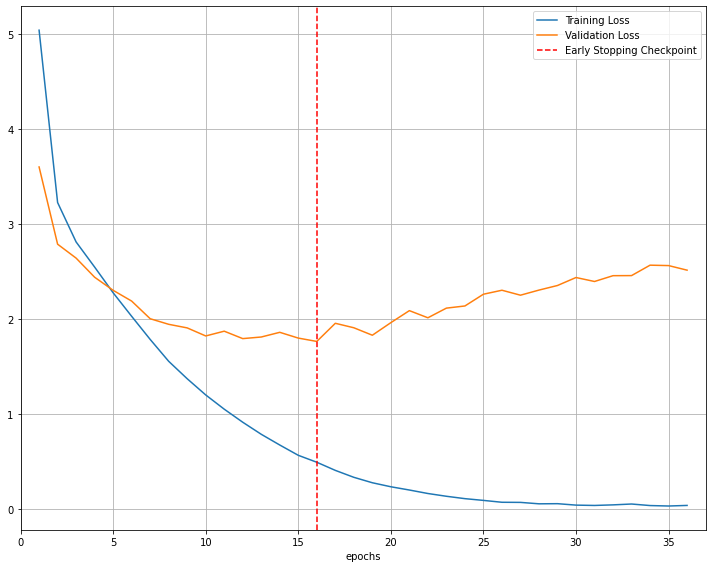

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
# 저장하기
state = {
        'epoch': 16,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': valid_loss,
}
path ="/content/drive/MyDrive/capstone_design/checkpoint.pth"
torch.save(state, path)

# 5. 테스트

#### 테스트 함수 작성

In [ ]:
# 7. 새로운 문장 테스트
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: compute predicted outputs by passing inputs to the model

        test_eval=[]
        for i in out:
            logits = i
            
            softmax_logit = torch.softmax(logits, dim=-1)
            softmax_logit = softmax_logit.squeeze()

            max_index = torch.argmax(softmax_logit).item()
            max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

            print('"', predict_sentence, '"')
            print('카테고리 : ', wellness_dialog_category[max_index][0])
            index = wellness_dialog_category[max_index][0]

            comment_list = wellness_dialog_system[index]
            print('코멘트 후보 : ', comment_list)

            comment_len = len(comment_list) - 1
            comment_index = random.randint(0, comment_len)
            print('코멘트 : ', comment_list[comment_index])

####테스트 실행

In [ ]:
predict('이번 일은 없던걸로 넘어가야겠어. 너무 짜증나.')
print('-'*80)
predict('제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요')
print('-'*80)
predict('얼른 끝내고 친구들이랑 놀러가고싶다')
print('-'*80)
predict('나 1등 됐어!')
print('-'*80)
predict('나 드디어 1등이야!!')
print('-'*80)
predict('주식 많이 떨어졌더라. 나 너무 슬퍼.')
print('-'*80)
predict('엄마 아빠가 싸우셨어. 이런 상황이 너무 싫어. 그만 싸우셨으면 좋겠어..')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


" 이번 일은 없던걸로 넘어가야겠어. 너무 짜증나. "
카테고리 :  감정/짜증
코멘트 후보 :  ['그런 일이 있었군요. 기분이 많이 나빴겠어요.', '으휴, 제가 대신 혼내주고 싶네요!', '달달한 걸 먹으면 짜증이 달아날 거예요.', '짜증이 날 때 일부러 크게 웃는 것도 좋은 방법인 것 같아요.']
코멘트 :  달달한 걸 먹으면 짜증이 달아날 거예요.
--------------------------------------------------------------------------------
" 제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요 "
카테고리 :  감정/감정조절이상
코멘트 후보 :  ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.', '저도 그 기분 이해해요. 많이 힘드시죠?', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.']
코멘트 :  감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
--------------------------------------------------------------------------------
" 얼른 끝내고 친구들이랑 놀러가고싶다 "
카테고리 :  배경/연애/이별
코멘트 후보 :  ['마음이 아프네요. 아름다운 사랑만큼 아름다운 이별은 왜 없는 걸까요?', '그런 일이 있으셨군요. 많이 허전하시겠어요. 괜찮으세요?', '충분히 슬퍼하고 나면 더 좋은 사람이 나타날 거라고 생각해요.']
코멘트 :  그런 일이 있으셨군요. 많이 허전하시겠어요. 괜찮으세요?
--------------------------------------------------------------------------------
" 나 1등 됐어! "
카테고리 :  배경/학업/우수
코멘트 후보 :  ['와, 대단하시네요!', '당신에게 행복한 기억이 되겠군요. 그 모든 게 쌓여서 당신이 행복했으면 좋겠어요.', '그 좋은 결과만큼 앞으로 당신의 미래도